In [45]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

# Configuration des paramètres globaux
plt.style.use('seaborn-v0_8-whitegrid')
Ke = 1e-14
pH_range = np.linspace(0, 14, 1000)
Cb = 0.20  # Concentration de la base

# Configuration des espèces acido-basiques
species_config = {
    'Acide citrique': {
        'pKas': [3.13, 4.76, 6.40],
        'Ca': 0.10,
        'Va': 10.0,
        'colors': ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'],
        'cmap': LinearSegmentedColormap.from_list('citrique', ['#2E86AB', '#C73E1D'])
    },
    'Acide phosphorique': {
        'pKas': [2.15, 7.20, 12.35],
        'Ca': 0.10,
        'Va': 10.0,
        'colors': ['#3A7D44', '#FFD166', '#06AED5', '#6A4C93'],
        'cmap': LinearSegmentedColormap.from_list('phosphorique', ['#3A7D44', '#6A4C93'])
    }
}


def calculate_species_distribution(pH, pKas):
    """Calcule la distribution des espèces"""
    x = 10**-pH
    Kas = [10**-pKa for pKa in pKas]
    
    denominator = np.ones_like(x)
    for i in range(1, len(Kas)+1):
        denominator += np.prod(Kas[:i]) / (x**i)
    
    alphas = [1 / denominator]
    for i in range(1, len(Kas)+1):
        alphas.append(np.prod(Kas[:i]) / (x**i) / denominator)
    
    return alphas

def calculate_titration_curve(pH, pKas, Ca, Va, Cb):
    """Calcule la courbe de titrage pour une espèce"""
    x = 10**-pH
    w = Ke/x - x
    alphas = calculate_species_distribution(pH, pKas)
    
    Y = sum(i*a for i, a in enumerate(alphas[1:], 1))
    V_verse = (Y + w/Ca) * Va * Ca / Cb
    
    return V_verse, alphas


Analyse de Acide citrique


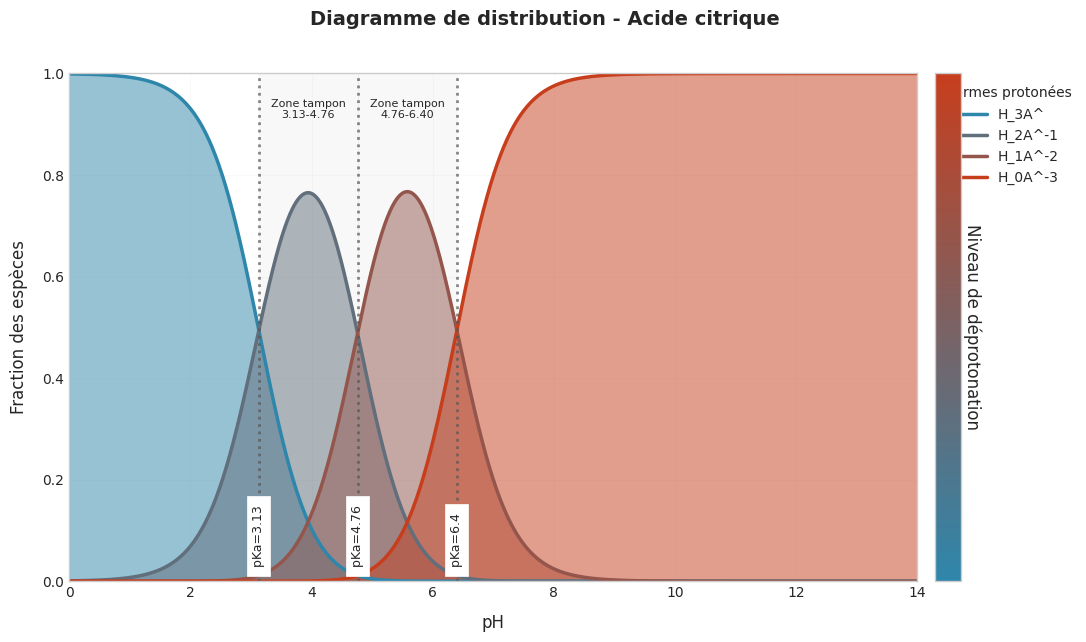


Analyse de Acide phosphorique


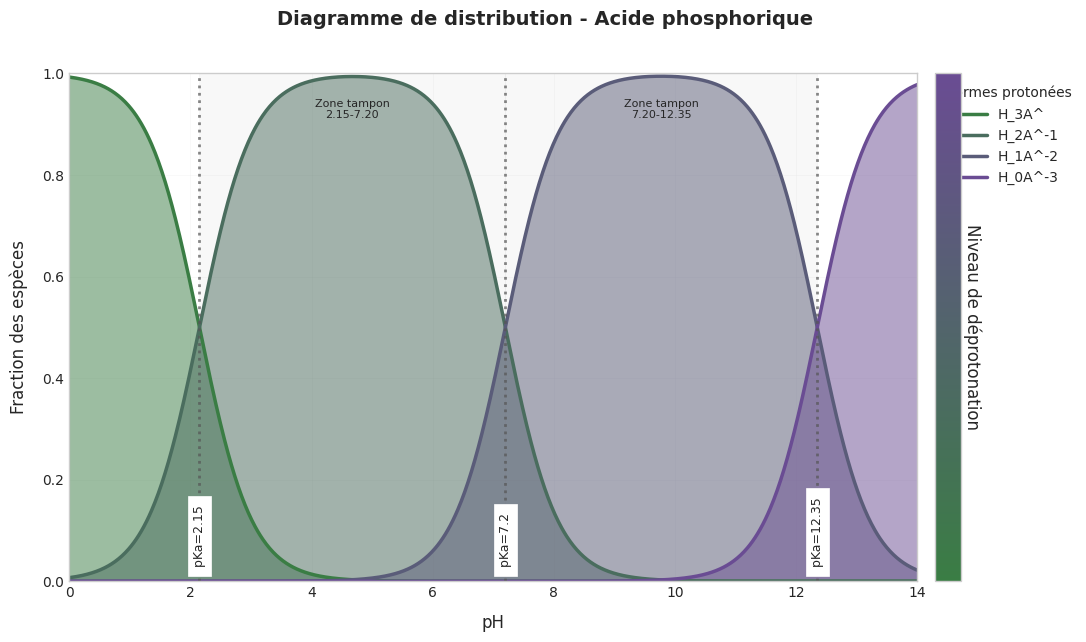

In [46]:
def create_distribution_plot(acide_name, data):
    """Crée un diagramme de distribution avec gradient de couleurs"""
    pKas = data['pKas']
    alphas = calculate_species_distribution(pH_range, pKas)
    n_species = len(alphas)
    
    fig, ax = plt.subplots(figsize=(11, 6.5))
    fig.suptitle(f"Diagramme de distribution - {acide_name}\n", fontsize=14, fontweight='bold')
    
    # Génération des labels et couleurs
    labels = [f"H_{n_species-1-j}A^{'-'*(j!=0)}{j if j!=0 else ''}" 
              for j in range(n_species)]
    
    # Création du gradient de couleur
    colors = data['cmap'](np.linspace(0, 1, n_species)) if 'cmap' in data else data['colors']
    
    # Tracé avec remplissage sous les courbes
    for i, (alpha, label) in enumerate(zip(alphas, labels)):
        ax.plot(pH_range, alpha, label=label, color=colors[i], linewidth=2.5)
        ax.fill_between(pH_range, 0, alpha, color=colors[i], alpha=0.5)
    
    # Lignes et annotations des pKa
    for pKa in pKas:
        ax.axvline(pKa, color='#555555', linestyle=':', alpha=0.7)
        ax.text(pKa, 0.02, f' pKa={pKa} ', ha='center', va='bottom', 
                rotation=90, backgroundcolor='white', fontsize=9)
    
    # Zone de pH tampon
    for i in range(len(pKas)-1):
        mid_pH = (pKas[i] + pKas[i+1])/2
        ax.axvspan(pKas[i], pKas[i+1], color='gray', alpha=0.05)
        ax.text(mid_pH, 0.95, f'Zone tampon\n{pKas[i]:.2f}-{pKas[i+1]:.2f}', 
                ha='center', va='top', fontsize=8)
    
    # Configuration esthétique
    ax.set_xlabel('pH', fontsize=12, labelpad=10)
    ax.set_ylabel('Fraction des espèces', fontsize=12, labelpad=10)
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 1)
    ax.grid(which='both', alpha=0.15)
    
    # Légende améliorée
    legend = ax.legend(title="Formes protonées", loc='upper left', 
                      bbox_to_anchor=(1.02, 1), framealpha=1)
    plt.setp(legend.get_title(), fontsize=10)
    
    # Barre de couleur indicative
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=data['cmap']), ax=ax, 
                        orientation='vertical', fraction=0.05, pad=0.02)
    cbar.set_label('Niveau de déprotonation', rotation=270, labelpad=15)
    cbar.set_ticks([])
    
    plt.tight_layout()
    plt.show()

# Génération des graphiques
for acide_name, data in species_config.items():
    print(f"\n{'='*50}\nAnalyse de {acide_name}\n{'='*50}")
    create_distribution_plot(acide_name, data)

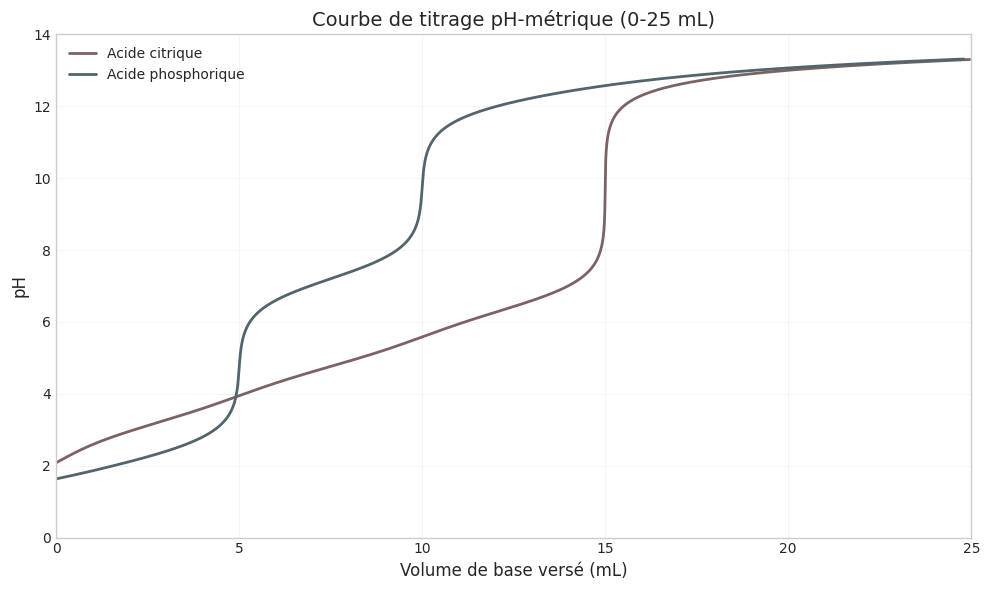

In [47]:
def plot_full_titration():
    """Courbe de titrage pour toutes les espèces (0-25 mL)"""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for name, data in species_config.items():
        V_verse, _ = calculate_titration_curve(pH_range, data['pKas'], 
                                             data['Ca'], data['Va'], Cb)
        
        # Filtrage des valeurs réalistes (0-25 mL)
        mask = (V_verse >= 0) & (V_verse <= 25)
        ax.plot(V_verse[mask], pH_range[mask], label=name, 
               color=data['cmap'](0.5), linewidth=2)
    
    ax.set_title("Courbe de titrage pH-métrique (0-25 mL)", fontsize=14)
    ax.set_xlabel("Volume de base versé (mL)", fontsize=12)
    ax.set_ylabel("pH", fontsize=12)
    ax.set_xlim(0, 25)
    ax.set_ylim(0, 14)
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_full_titration()

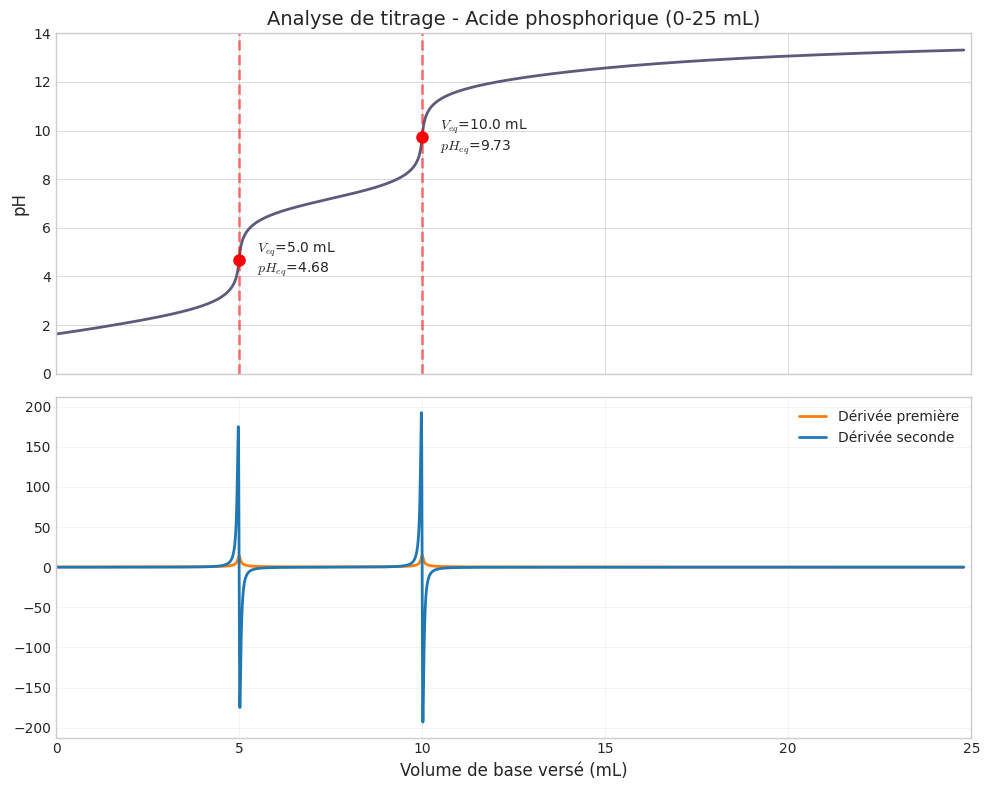

In [59]:
def plot_derivative_analysis(acide_name):
    """Analyse des dérivées avec échelle 0-25 mL"""
    data = species_config[acide_name]
    V_verse, _ = calculate_titration_curve(pH_range, data['pKas'],
                                         data['Ca'], data['Va'], Cb)
    
    # Filtrage des valeurs réalistes
    mask = (V_verse >= 0) & (V_verse <= 25)
    V_verse = V_verse[mask]
    pH_filtered = pH_range[mask]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # Courbe de titrage
    ax1.plot(V_verse, pH_filtered, color=data['cmap'](0.7), linewidth=2)
    ax1.set_ylabel("pH", fontsize=12)
    ax1.set_xlim(0, 25)
    ax1.set_ylim(0, 14)
    
    # Calcul des dérivées
    dpH = np.gradient(pH_filtered, V_verse)
    d2pH = np.gradient(dpH, V_verse)
    
    # Détection des équivalences
    for i in range(len(d2pH)-1):
        if d2pH[i]*d2pH[i+1] < 0 and abs(dpH[i]) > 0.4:
            Veq = V_verse[i]
            pHeq = pH_filtered[i]
            ax1.axvline(Veq, color='r', linestyle='--', alpha=0.5)
            ax1.plot(Veq, pHeq, 'ro', markersize=8)
            ax1.text(Veq+0.5, pHeq, r'$V_{eq}$'f"={Veq:.1f} mL\n"  r'$pH_{eq}$'f"={pHeq:.2f}", 
                    ha='left', va='center')
    
    ax1.set_title(f"Analyse de titrage - {acide_name} (0-25 mL)", fontsize=14)
    
    # Dérivées
    ax2.plot(V_verse, dpH, label='Dérivée première', color='#FF7F0E')
    ax2.plot(V_verse, d2pH, label='Dérivée seconde', color='#1F77B4')
    ax2.legend()
    ax2.set_xlabel("Volume de base versé (mL)", fontsize=12)
    ax2.grid(alpha=0.3)
    ax2.set_xlim(0, 25)
    
    plt.tight_layout()
    plt.show()

plot_derivative_analysis('Acide phosphorique')

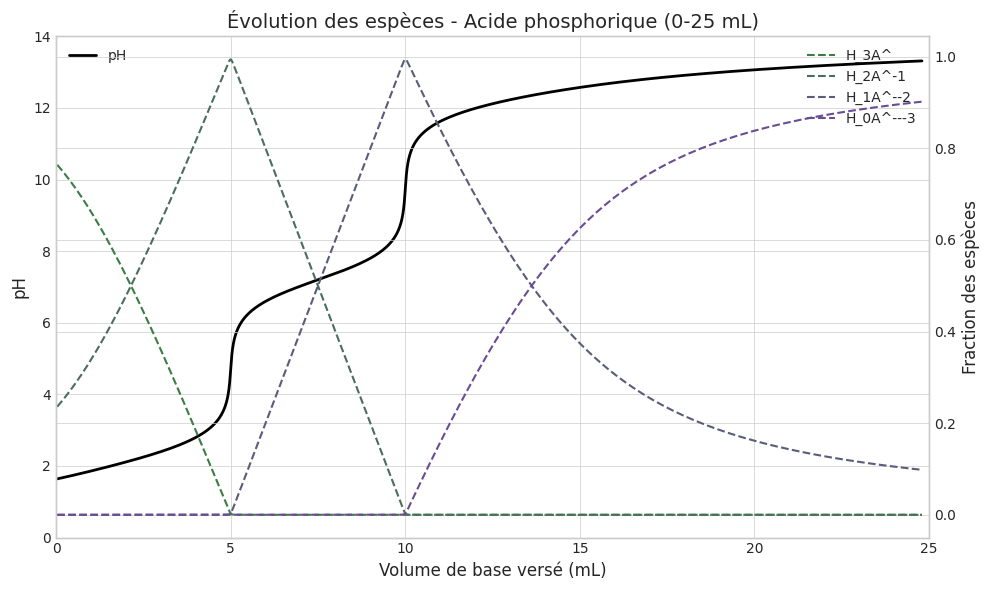

In [49]:
def plot_species_evolution(acide_name):
    """Évolution des espèces (0-25 mL)"""
    data = species_config[acide_name]
    V_verse, alphas = calculate_titration_curve(pH_range, data['pKas'],
                                              data['Ca'], data['Va'], Cb)
    
    # Filtrage des valeurs réalistes
    mask = (V_verse >= 0) & (V_verse <= 25)
    V_verse = V_verse[mask]
    pH_filtered = pH_range[mask]
    alphas = [alpha[mask] for alpha in alphas]
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    colors = data['cmap'](np.linspace(0, 1, len(alphas)))
    
    # Courbe de titrage
    ax1.plot(V_verse, pH_filtered, color='k', label='pH', linewidth=2)
    ax1.set_xlabel("Volume de base versé (mL)", fontsize=12)
    ax1.set_ylabel("pH", fontsize=12)
    ax1.set_xlim(0, 25)
    ax1.set_ylim(0, 14)
    
    # Proportions des espèces
    ax2 = ax1.twinx()
    for i, alpha in enumerate(alphas):
        label = f"H_{len(data['pKas'])-i}A^{'-'*i}{i if i else ''}"
        ax2.plot(V_verse, alpha, '--', color=colors[i], label=label, linewidth=1.5)
    
    ax2.set_ylabel("Fraction des espèces", fontsize=12)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.title(f"Évolution des espèces - {acide_name} (0-25 mL)", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_species_evolution('Acide phosphorique')

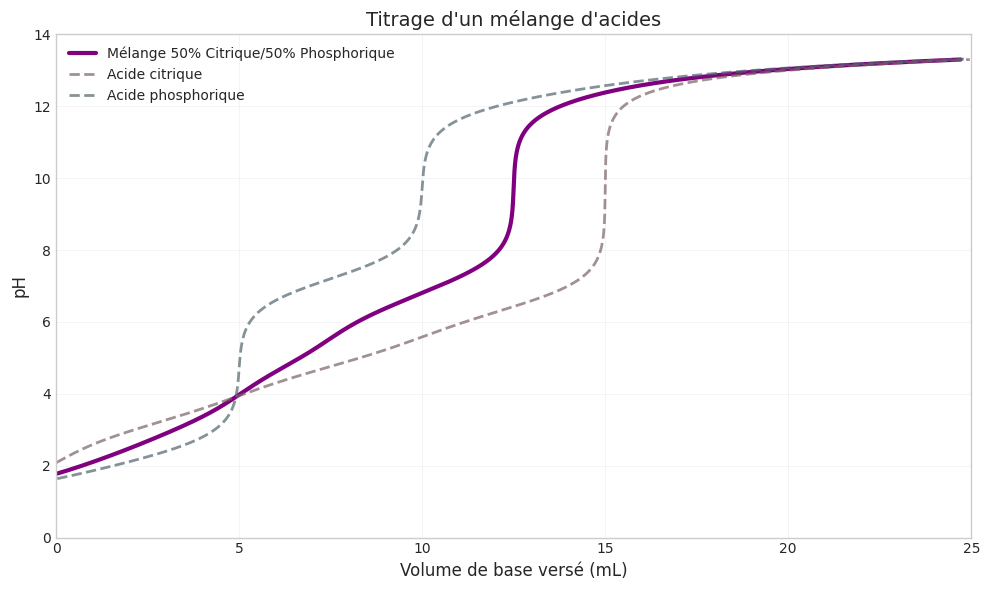

In [68]:
def plot_acid_mixture_titration():
    """Titrage d'un mélange d'acides selon l'article"""
    # Paramètres du mélange (exemple avec 50/50)
    mixture_ratio = 0.5  # Rapport de mélange (0-1)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Calcul pour chaque acide séparément
    V_verses = []
    for name, data in species_config.items():
        V_verse, _ = calculate_titration_curve(pH_range, data['pKas'],
                                             data['Ca'], data['Va'], Cb)
        # Application du ratio de mélange
        V_verses.append(V_verse * mixture_ratio)
    
    # Courbe du mélange (somme pondérée)
    V_mix = np.sum(V_verses, axis=0)
    
    # Filtrage des valeurs réalistes
    mask = (V_mix >= 0) & (V_mix <= 25)
    
    # Tracé
    ax.plot(V_mix[mask], pH_range[mask], 
           label=f'Mélange {int(mixture_ratio*100)}% Citrique/{int((1-mixture_ratio)*100)}% Phosphorique',
           color='purple', linewidth=3)
    
    # Tracé des acides purs pour comparaison
    for name, data in species_config.items():
        V_verse, _ = calculate_titration_curve(pH_range, data['pKas'],
                                             data['Ca'], data['Va'], Cb)
        mask = (V_verse >= 0) & (V_verse <= 25)
        ax.plot(V_verse[mask], pH_range[mask], '--',
               label=name, color=data['cmap'](0.5), alpha=0.7)
    
    # Configuration du graphique
    ax.set_title("Titrage d'un mélange d'acides", fontsize=14)
    ax.set_xlabel("Volume de base versé (mL)", fontsize=12)
    ax.set_ylabel("pH", fontsize=12)
    ax.set_xlim(0, 25)
    ax.set_ylim(0, 14)
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_acid_mixture_titration()

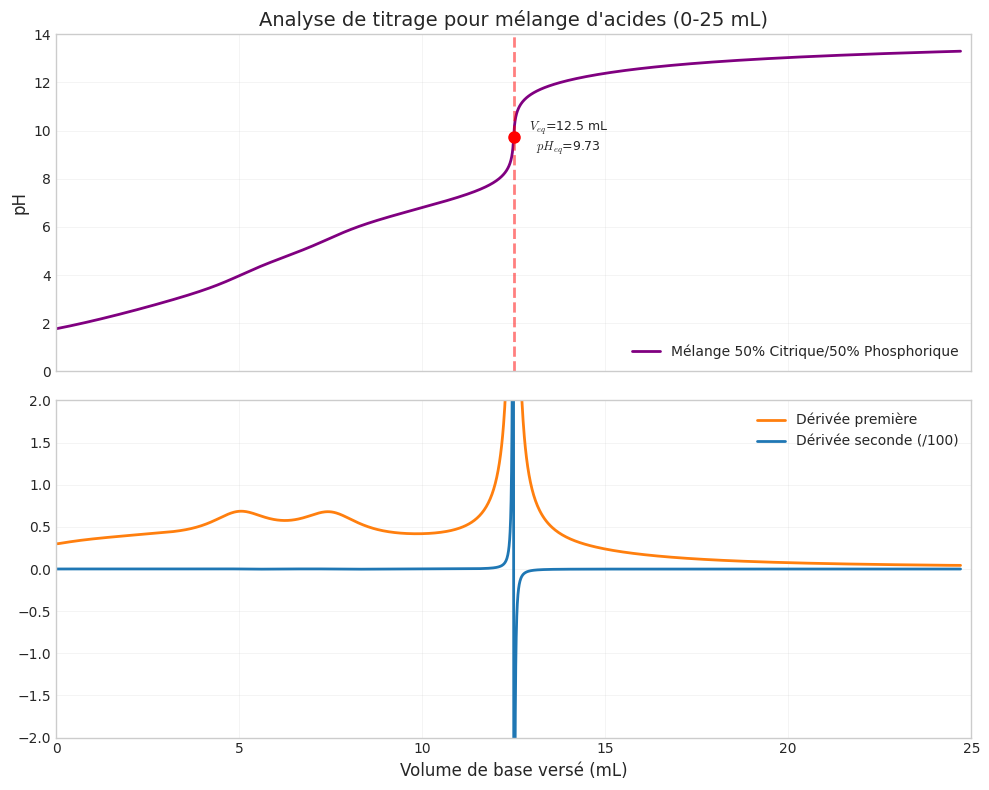


Points d'équivalence détectés:
-----------------------------
Volume (mL) | pH
-----------------------------
12.50        | 9.73


In [66]:
def plot_mixture_derivative_analysis(mixture_ratio=0.2):
    """Analyse des dérivées pour un mélange d'acides avec détection des équivalences"""
    # Calcul des courbes individuelles pondérées
    V_verses = []
    for data in species_config.values():
        V_verse, _ = calculate_titration_curve(pH_range, data['pKas'],
                                             data['Ca'], data['Va'], Cb)
        V_verses.append(V_verse * mixture_ratio)
    
    # Courbe du mélange
    V_mix = np.sum(V_verses, axis=0)
    mask = (V_mix >= 0) & (V_mix <= 25)
    V_mix = V_mix[mask]
    pH_filtered = pH_range[mask]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # 1. Courbe de titrage du mélange
    ax1.plot(V_mix, pH_filtered, color='purple', linewidth=2, 
             label=f'Mélange {int(mixture_ratio*100)}% Citrique/{int((1-mixture_ratio)*100)}% Phosphorique')
    
    # 2. Calcul des dérivées
    dpH = np.gradient(pH_filtered, V_mix)
    d2pH = np.gradient(dpH, V_mix)
    
    # 3. Détection automatique des équivalences
    equivalence_points = []
    for i in range(len(d2pH)-1):
        if d2pH[i]*d2pH[i+1] < 0 and abs(dpH[i]) > 0.9:  # Seuil de pente
            Veq = V_mix[i]
            pHeq = pH_filtered[i]
            equivalence_points.append((Veq, pHeq))
            
            # Marquage sur la courbe
            ax1.axvline(Veq, color='r', linestyle='--', alpha=0.5)
            ax1.plot(Veq, pHeq, 'ro', markersize=8)
            ax1.text(Veq+1.5, pHeq-0.8, r'$V_{eq}$'f"={Veq:.1f} mL\n"r'$pH_{eq}$'f"={pHeq:.2f}", 
                    ha='center', va='bottom', fontsize=9)
    
    # Configuration graphique
    ax1.set_title(f"Analyse de titrage pour mélange d'acides (0-25 mL)", fontsize=14)
    ax1.set_ylabel("pH", fontsize=12)
    ax1.legend(loc='lower right')
    ax1.grid(alpha=0.3)
    ax1.set_xlim(0, 25)
    ax1.set_ylim(0, 14)
    
    # 4. Tracé des dérivées
    ax2.plot(V_mix, dpH, label='Dérivée première', color='#FF7F0E')
    ax2.plot(V_mix, d2pH*0.01, label='Dérivée seconde (/100)', color='#1F77B4')
    ax2.legend()
    ax2.set_xlabel("Volume de base versé (mL)", fontsize=12)
    ax2.grid(alpha=0.3)
    ax2.set_ylim(-2, 2)
    
    plt.tight_layout()
    plt.show()
    
    # Affichage texte des résultats
    print("\nPoints d'équivalence détectés:")
    print("-----------------------------")
    print("Volume (mL) | pH")
    print("-----------------------------")
    for Veq, pHeq in equivalence_points:
        print(f"{Veq:.2f}        | {pHeq:.2f}")

# Exemple d'utilisation (50/50 par défaut)
plot_mixture_derivative_analysis(mixture_ratio=0.5)

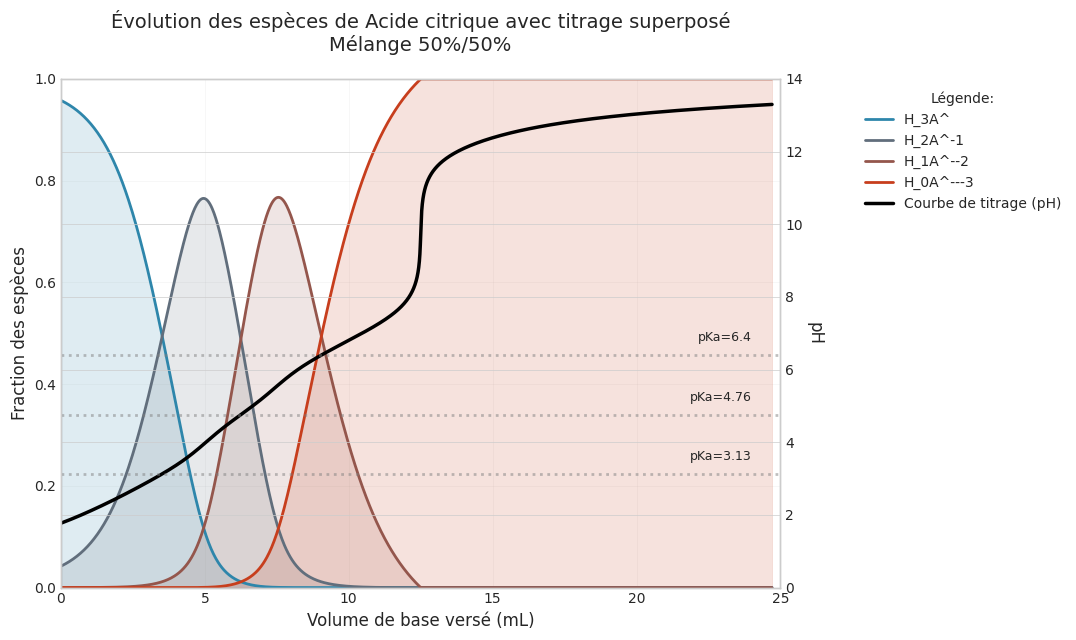

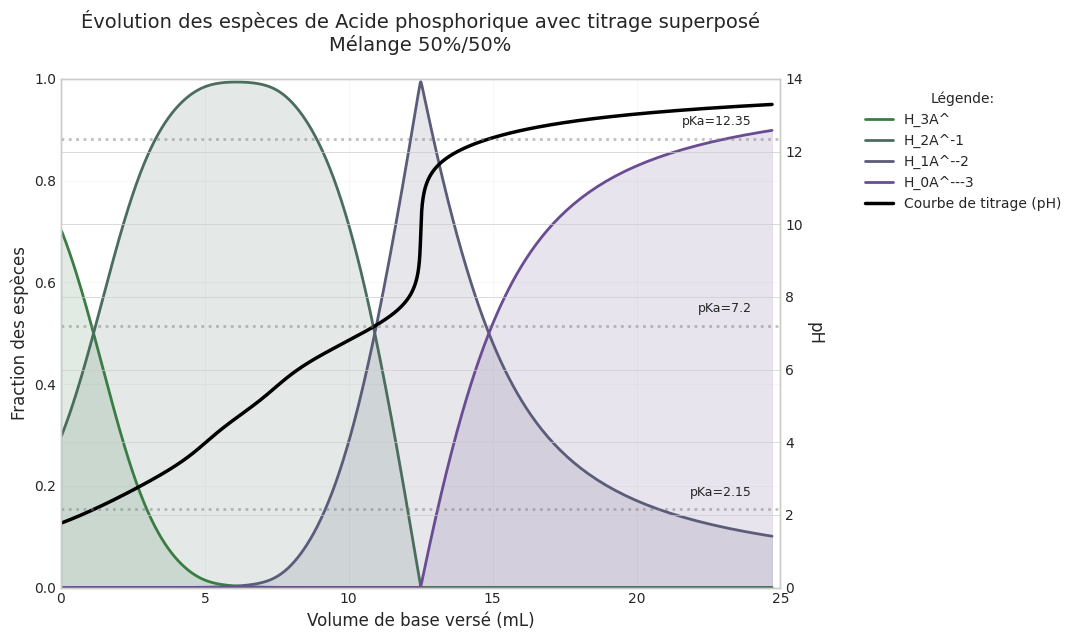

In [57]:
def plot_combined_distribution_and_titration(mixture_ratio=0.5):
    """Diagrammes de distribution avec courbe de titrage superposée"""
    # Calcul des données pour le mélange
    V_verses = []
    all_alphas = []
    pH_data = []
    
    for name, data in species_config.items():
        V_verse, alphas = calculate_titration_curve(pH_range, data['pKas'],
                                                   data['Ca'], data['Va'], Cb)
        V_verses.append(V_verse * mixture_ratio)
        all_alphas.append(alphas)
        pH_data.append(pH_range)
    
    V_mix = np.sum(V_verses, axis=0)
    mask = (V_mix >= 0) & (V_mix <= 25)
    V_mix = V_mix[mask]
    pH_mix = np.mean(pH_data, axis=0)[mask]  # pH moyen du mélange

    # Création des graphiques combinés
    for idx, (name, data) in enumerate(species_config.items()):
        fig, ax1 = plt.subplots(figsize=(11, 6.5))
        
        # ========================
        # 1. Diagramme de distribution (ax1)
        # ========================
        alphas = [alpha[mask] for alpha in all_alphas[idx]]
        n_species = len(alphas)
        colors = data['cmap'](np.linspace(0, 1, n_species))
        
        for i, alpha in enumerate(alphas):
            label = f"H_{n_species-1-i}A^{'-'*i}{i if i else ''}"
            ax1.plot(V_mix, alpha, label=label, 
                    color=colors[i], linewidth=2)
            ax1.fill_between(V_mix, 0, alpha, 
                           color=colors[i], alpha=0.15)

        ax1.set_xlabel("Volume de base versé (mL)", fontsize=12)
        ax1.set_ylabel("Fraction des espèces", fontsize=12)
        ax1.set_xlim(0, 25)
        ax1.set_ylim(0, 1)
        ax1.grid(alpha=0.2)
        
        # ========================
        # 2. Courbe de titrage (ax2)
        # ========================
        ax2 = ax1.twinx()
        ax2.plot(V_mix, pH_mix, color='black', 
                linestyle='-', linewidth=2.5, 
                label='Courbe de titrage (pH)')
        ax2.set_ylabel("pH", fontsize=12, rotation=270, labelpad=15)
        ax2.set_ylim(0, 14)
        
        # ========================
        # Configuration commune
        # ========================
        plt.title(f"Évolution des espèces de {name} avec titrage superposé\n"
                f"Mélange {int(mixture_ratio*100)}%/{int((1-mixture_ratio)*100)}%", 
                fontsize=14, pad=20)
        
        # Légendes combinées
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2,
                 loc='upper left', bbox_to_anchor=(1.1, 1),
                 title="Légende:")
        
        # Ajout des pKa comme repères
        for pKa in data['pKas']:
            ax2.axhline(pKa, color='gray', linestyle=':', alpha=0.5)
            ax2.text(24, pKa+0.3, f'pKa={pKa}', 
                    ha='right', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.show()

# Exemple d'utilisation
plot_combined_distribution_and_titration(mixture_ratio=0.5)